<a href="https://colab.research.google.com/github/aatudaboss/Credit-Card-Input/blob/main/LTV_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import math

from datetime import datetime, timedelta
import random
#import datetime

import string
!pip install names
import names

import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 798kB 2.8MB/s 
  Created wheel for names: filename=names-0.3.0-cp36-none-any.whl size=803689 sha256=d553487fd0a6275f63fc969707753f672ba305a4acba0092a077b85b40d701d9
  Stored in directory: /root/.cache/pip/wheels/f9/a5/e1/be3e0aaa6fa285575078fa2aafd9959b45bdbc8de8a6803aeb
Successfully built names


In [ ]:
random.seed(42)

In [ ]:
# import seaborn as sns
# # from matplotlib import pyplot as plt
# sns.set(rc={'figure.figsize':(11.7,8.27)})

# Generating Dummy Data

For a subscription service company (SaaS or alike)

In [ ]:
last_names = [
    'banana','funny','happy','pizza','lovely', 'vegan', 'cool', 'beans', 'smart', 'cheesy', 'cashew', 'adorable', 'pants',
    'annoying', 'freeing', 'candid', 'enjoyable', 'sweet', 'lazy', 'red', 'cup', 'coffee', 'greenery', 'hope',
    'peace', 'love', 'beauty', 'data'
]

first_names = list(set([names.get_first_name().lower() for i in range(10000)]))

In [ ]:
def generate_dummy_names(first_name,last_name,number_names=1000):
    """
    function generates random name combinations of the provided adjectives and subjects
    >>> name_generator(adj=['cool','strong'],sub=['harry','kate'],number_names=3)
    ['cool_harry', 'strong_kate', 'strong_harry', 'cool_kate']
    """
    if number_names > len(first_name)*len(last_name):
        raise ValueError(f"""
            Can at most genereate {len(first_name)*len(last_name) -1} names, increase adj or sub to allow for more names
            """)
    res = set()
    while len(res) < number_names:
        new_name = f'{np.random.choice(first_name)}_{np.random.choice(last_name)}'
        res = res | set([new_name])
    return list(res)

In [ ]:
def generate_dummy_date(start_date, end_date):
  """
  Takes in 2 date strings in 'YYYY-MM-DD' format
  And returns a random date in between those dates
  """
  time_between_dates = pd.to_datetime(end_date) - pd.to_datetime(start_date)
  days_between_dates = time_between_dates.days
  random_number_of_days = random.randrange(days_between_dates)
  return pd.to_datetime(start_date) + timedelta(days=random_number_of_days)

In [ ]:
def month_diff(start_date, end_date):
  return (pd.to_datetime(end_date).year -pd.to_datetime(start_date).year) * 12 + (pd.to_datetime(end_date).month - pd.to_datetime(start_date).month)

In [ ]:
def generate_random_df(customers, start_date, end_date, rows = 10000):
  maturity = month_diff(start_date, end_date)
  df = pd.DataFrame({
      'customer_name' : customers,
      'subscription_date' : [generate_dummy_date(start_date, end_date) for i in range(rows)],
      'maturity' : [random.randint(0, maturity + 1) for i in range(rows)],
      'value' : [random.randrange(100,400, 100) for i in range(rows)]
  }
  )
  # correcting maturity to not exceed end_date - start_date
  # also adding subscription_date BOM = beginning of month
  df = df.assign(maturity = [month_diff(y, end_date) if x > month_diff(y, end_date) else x for x,y in df[['maturity', 'subscription_date']].values]
                 , subscription_bom = df.subscription_date.values.astype('datetime64[M]').astype(dtype='datetime64[D]')
                 )

  return df

In [ ]:
end_date = '2020-11-01'
start_date = '2018-01-01'

In [ ]:
customers = generate_dummy_names(first_names, last_names, number_names = 4000)

In [ ]:
random_df = generate_random_df(customers, start_date=start_date, end_date=end_date, rows=4000)

In [ ]:
random_df

,customer_name,subscription_date,maturity,value,subscription_bom
0,wilfred_adorable,2018-01-29,22,300,2018-01-01
1,eveline_funny,2018-07-15,1,100,2018-07-01
2,pedro_beans,2019-06-30,17,300,2019-06-01
3,lolita_funny,2019-01-13,20,100,2019-01-01
4,leroy_peace,2020-03-25,3,300,2020-03-01
...,...,...,...,...,...
3995,haley_sweet,2019-09-08,14,100,2019-09-01
3996,talisha_coffee,2019-05-15,18,300,2019-05-01
3997,linnea_love,2020-05-31,6,100,2020-05-01
3998,beaulah_pants,2019-11-22,2,300,2019-11-01


# Calculating Retention

In [ ]:
"""
Cohort size here is the number of customers from a cohort
that reached maturity in a column
"""
group = random_df.groupby(['subscription_bom', 'maturity'])
cohort_data = group['customer_name'].nunique().reset_index().rename(columns = {'customer_name':'cohort_size'})

cohort_data

,subscription_bom,maturity,cohort_size
0,2018-01-01,0,2
1,2018-01-01,1,6
2,2018-01-01,2,5
3,2018-01-01,3,3
4,2018-01-01,4,2
...,...,...,...
600,2020-09-01,0,6
601,2020-09-01,1,4
602,2020-09-01,2,96
603,2020-10-01,0,3


In [ ]:
"""
this matrix has 2 axes:
x - cohort date (beginning of month); y - cohort maturity (in months)
every cell is a unique count of customer for the x and y

"""
retention = cohort_data.pivot(index='subscription_bom', columns='maturity', values='cohort_size').sort_index(ascending = True)

retention

maturity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
subscription_bom,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2.0,6.0,5.0,3.0,2.0,2.0,9.0,4.0,3.0,3.0,4.0,2.0,3.0,1.0,4.0,4.0,1.0,4.0,2.0,10.0,4.0,3.0,6.0,2.0,6.0,3.0,8.0,5.0,2.0,8.0,6.0,3.0,3.0,2.0,13.0
2018-02-01,3.0,3.0,3.0,7.0,NaN,1.0,2.0,NaN,5.0,4.0,2.0,1.0,1.0,3.0,2.0,4.0,1.0,3.0,4.0,3.0,3.0,7.0,3.0,3.0,4.0,2.0,3.0,5.0,5.0,2.0,NaN,3.0,5.0,15.0,NaN
2018-03-01,1.0,3.0,9.0,1.0,4.0,6.0,4.0,4.0,5.0,2.0,4.0,2.0,2.0,2.0,4.0,4.0,4.0,6.0,2.0,2.0,5.0,3.0,4.0,1.0,3.0,1.0,1.0,5.0,NaN,3.0,5.0,5.0,13.0,NaN,NaN
2018-04-01,5.0,5.0,3.0,NaN,2.0,1.0,4.0,2.0,3.0,4.0,3.0,2.0,2.0,4.0,5.0,3.0,4.0,3.0,2.0,7.0,NaN,5.0,4.0,5.0,NaN,5.0,4.0,1.0,1.0,6.0,6.0,15.0,NaN,NaN,NaN
2018-05-01,NaN,2.0,3.0,2.0,6.0,3.0,3.0,7.0,1.0,3.0,1.0,4.0,2.0,4.0,4.0,5.0,6.0,3.0,3.0,2.0,4.0,4.0,4.0,5.0,2.0,5.0,2.0,3.0,3.0,3.0,24.0,NaN,NaN,NaN,NaN
2018-06-01,6.0,NaN,2.0,5.0,6.0,3.0,1.0,2.0,2.0,4.0,NaN,3.0,5.0,1.0,3.0,6.0,3.0,2.0,1.0,1.0,1.0,5.0,2.0,3.0,10.0,5.0,5.0,2.0,3.0,13.0,NaN,NaN,NaN,NaN,NaN
2018-07-01,3.0,5.0,3.0,2.0,1.0,8.0,6.0,4.0,2.0,4.0,3.0,2.0,4.0,1.0,6.0,3.0,NaN,1.0,NaN,7.0,3.0,5.0,6.0,7.0,4.0,2.0,1.0,2.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01,2.0,1.0,3.0,3.0,3.0,2.0,4.0,NaN,3.0,1.0,1.0,2.0,4.0,4.0,3.0,4.0,5.0,5.0,1.0,3.0,3.0,4.0,1.0,2.0,2.0,3.0,2.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,5.0,4.0,1.0,NaN,2.0,5.0,4.0,6.0,3.0,2.0,2.0,7.0,4.0,3.0,5.0,1.0,4.0,3.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""
if a customer's last order was in period 2,
they were active in period 0, 1 as well
same for other periods
"""
retention_sub = retention.copy()
for row_loc in range(retention.shape[0]):
  for col_loc in range(retention.shape[1]):
    retention_sub.iloc[row_loc, col_loc] = np.sum(retention_sub.iloc[row_loc, col_loc:])

In [ ]:
retention_sub

maturity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
subscription_bom,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,148.0,146.0,140.0,135.0,132.0,130.0,128.0,119.0,115.0,112.0,109.0,105.0,103.0,100.0,99.0,95.0,91.0,90.0,86.0,84.0,74.0,70.0,67.0,61.0,59.0,53.0,50.0,42.0,37.0,35.0,27.0,21.0,18.0,15.0,13.0
2018-02-01,112.0,109.0,106.0,103.0,96.0,96.0,95.0,93.0,93.0,88.0,84.0,82.0,81.0,80.0,77.0,75.0,71.0,70.0,67.0,63.0,60.0,57.0,50.0,47.0,44.0,40.0,38.0,35.0,30.0,25.0,23.0,23.0,20.0,15.0,0.0
2018-03-01,120.0,119.0,116.0,107.0,106.0,102.0,96.0,92.0,88.0,83.0,81.0,77.0,75.0,73.0,71.0,67.0,63.0,59.0,53.0,51.0,49.0,44.0,41.0,37.0,36.0,33.0,32.0,31.0,26.0,26.0,23.0,18.0,13.0,0.0,0.0
2018-04-01,116.0,111.0,106.0,103.0,103.0,101.0,100.0,96.0,94.0,91.0,87.0,84.0,82.0,80.0,76.0,71.0,68.0,64.0,61.0,59.0,52.0,52.0,47.0,43.0,38.0,38.0,33.0,29.0,28.0,27.0,21.0,15.0,0.0,0.0,0.0
2018-05-01,123.0,123.0,121.0,118.0,116.0,110.0,107.0,104.0,97.0,96.0,93.0,92.0,88.0,86.0,82.0,78.0,73.0,67.0,64.0,61.0,59.0,55.0,51.0,47.0,42.0,40.0,35.0,33.0,30.0,27.0,24.0,0.0,0.0,0.0,0.0
2018-06-01,105.0,99.0,99.0,97.0,92.0,86.0,83.0,82.0,80.0,78.0,74.0,74.0,71.0,66.0,65.0,62.0,56.0,53.0,51.0,50.0,49.0,48.0,43.0,41.0,38.0,28.0,23.0,18.0,16.0,13.0,0.0,0.0,0.0,0.0,0.0
2018-07-01,127.0,124.0,119.0,116.0,114.0,113.0,105.0,99.0,95.0,93.0,89.0,86.0,84.0,80.0,79.0,73.0,70.0,70.0,69.0,69.0,62.0,59.0,54.0,48.0,41.0,37.0,35.0,34.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-01,93.0,91.0,90.0,87.0,84.0,81.0,79.0,75.0,75.0,72.0,71.0,70.0,68.0,64.0,60.0,57.0,53.0,48.0,43.0,42.0,39.0,36.0,32.0,31.0,29.0,27.0,24.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-01,115.0,112.0,108.0,106.0,103.0,100.0,96.0,95.0,94.0,89.0,85.0,84.0,84.0,82.0,77.0,73.0,67.0,64.0,62.0,60.0,53.0,49.0,46.0,41.0,40.0,36.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cohorts = retention_sub[0].reset_index().rename(columns={0:'cohort_size'})
cohorts

,subscription_bom,cohort_size
0,2018-01-01,148.0
1,2018-02-01,112.0
2,2018-03-01,120.0
3,2018-04-01,116.0
4,2018-05-01,123.0
5,2018-06-01,105.0
6,2018-07-01,127.0
7,2018-08-01,93.0
8,2018-09-01,115.0
9,2018-10-01,136.0


In [ ]:
"""
Cohort retention matrix shows how many of the cohort
moved from maturity t to maturity t+1 (renewed sunscription)
"""
retention_matrix = retention_sub.divide(retention_sub[0], axis=0).round(4)
retention_matrix.sort_index

<bound method DataFrame.sort_index of maturity           0       1       2       3   ...      31      32      33      34
subscription_bom                               ...                                
2018-01-01        1.0  0.9865  0.9459  0.9122  ...  0.1419  0.1216  0.1014  0.0878
2018-02-01        1.0  0.9732  0.9464  0.9196  ...  0.2054  0.1786  0.1339  0.0000
2018-03-01        1.0  0.9917  0.9667  0.8917  ...  0.1500  0.1083  0.0000  0.0000
2018-04-01        1.0  0.9569  0.9138  0.8879  ...  0.1293  0.0000  0.0000  0.0000
2018-05-01        1.0  1.0000  0.9837  0.9593  ...  0.0000  0.0000  0.0000  0.0000
2018-06-01        1.0  0.9429  0.9429  0.9238  ...  0.0000  0.0000  0.0000  0.0000
2018-07-01        1.0  0.9764  0.9370  0.9134  ...  0.0000  0.0000  0.0000  0.0000
2018-08-01        1.0  0.9785  0.9677  0.9355  ...  0.0000  0.0000  0.0000  0.0000
2018-09-01        1.0  0.9739  0.9391  0.9217  ...  0.0000  0.0000  0.0000  0.0000
2018-10-01        1.0  0.9632  0.9485  0.9338  ..

In [ ]:
df_zero = pd.DataFrame(np.zeros((retention_matrix.shape[0]
                       , retention_matrix.shape[1]))
                       , index = retention_sub.index)

In [ ]:
"""
Marginal retention matrix is calculated for all the columns except first
by division of a column that corresponds to t+1 maturity by t
In other words, it tells us how many customers who reached maturity t moved to t+1
"""

df_marginal = df_zero.copy()
# dividing each column (except ind = 0) by the previous one
#for i in np.unique(df.order_age_wmax.values):
for i in retention_matrix.columns.values:
  if i == 0:
    df_marginal.iloc[:, i] = retention_sub[i].divide(retention_sub[i], axis = 0)
  else:
    df_marginal.iloc[:, i] = retention_sub[i].divide(retention_sub[i-1], axis = 0)

df_marginal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
subscription_bom,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.0,0.986486,0.958904,0.964286,0.977778,0.984848,0.984615,0.929688,0.966387,0.973913,0.973214,0.963303,0.980952,0.970874,0.990000,0.959596,0.957895,0.989011,0.955556,0.976744,0.880952,0.945946,0.957143,0.910448,0.967213,0.898305,0.943396,0.840000,0.880952,0.945946,0.771429,0.777778,0.857143,0.833333,0.866667
2018-02-01,1.0,0.973214,0.972477,0.971698,0.932039,1.000000,0.989583,0.978947,1.000000,0.946237,0.954545,0.976190,0.987805,0.987654,0.962500,0.974026,0.946667,0.985915,0.957143,0.940299,0.952381,0.950000,0.877193,0.940000,0.936170,0.909091,0.950000,0.921053,0.857143,0.833333,0.920000,1.000000,0.869565,0.750000,0.000000
2018-03-01,1.0,0.991667,0.974790,0.922414,0.990654,0.962264,0.941176,0.958333,0.956522,0.943182,0.975904,0.950617,0.974026,0.973333,0.972603,0.943662,0.940299,0.936508,0.898305,0.962264,0.960784,0.897959,0.931818,0.902439,0.972973,0.916667,0.969697,0.968750,0.838710,1.000000,0.884615,0.782609,0.722222,0.000000,NaN
2018-04-01,1.0,0.956897,0.954955,0.971698,1.000000,0.980583,0.990099,0.960000,0.979167,0.968085,0.956044,0.965517,0.976190,0.975610,0.950000,0.934211,0.957746,0.941176,0.953125,0.967213,0.881356,1.000000,0.903846,0.914894,0.883721,1.000000,0.868421,0.878788,0.965517,0.964286,0.777778,0.714286,0.000000,NaN,NaN
2018-05-01,1.0,1.000000,0.983740,0.975207,0.983051,0.948276,0.972727,0.971963,0.932692,0.989691,0.968750,0.989247,0.956522,0.977273,0.953488,0.951220,0.935897,0.917808,0.955224,0.953125,0.967213,0.932203,0.927273,0.921569,0.893617,0.952381,0.875000,0.942857,0.909091,0.900000,0.888889,0.000000,NaN,NaN,NaN
2018-06-01,1.0,0.942857,1.000000,0.979798,0.948454,0.934783,0.965116,0.987952,0.975610,0.975000,0.948718,1.000000,0.959459,0.929577,0.984848,0.953846,0.903226,0.946429,0.962264,0.980392,0.980000,0.979592,0.895833,0.953488,0.926829,0.736842,0.821429,0.782609,0.888889,0.812500,0.000000,NaN,NaN,NaN,NaN
2018-07-01,1.0,0.976378,0.959677,0.974790,0.982759,0.991228,0.929204,0.942857,0.959596,0.978947,0.956989,0.966292,0.976744,0.952381,0.987500,0.924051,0.958904,1.000000,0.985714,1.000000,0.898551,0.951613,0.915254,0.888889,0.854167,0.902439,0.945946,0.971429,0.941176,0.000000,NaN,NaN,NaN,NaN,NaN
2018-08-01,1.0,0.978495,0.989011,0.966667,0.965517,0.964286,0.975309,0.949367,1.000000,0.960000,0.986111,0.985915,0.971429,0.941176,0.937500,0.950000,0.929825,0.905660,0.895833,0.976744,0.928571,0.923077,0.888889,0.968750,0.935484,0.931034,0.888889,0.916667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,1.0,0.973913,0.964286,0.981481,0.971698,0.970874,0.960000,0.989583,0.989474,0.946809,0.955056,0.988235,1.000000,0.976190,0.939024,0.948052,0.917808,0.955224,0.968750,0.967742,0.883333,0.924528,0.938776,0.891304,0.975610,0.900000,0.916667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""
Marginal retention by taking an average of the previous N rows
Here is where you would like to consider seasonality.

Notice that using mean() function can be not always desirable.
This is due to a reason that some values in previous rows might contain 0's.
We want to average non-zero values in the previous N rows.
Including zeros will significantly affect the resulting retention matrix.
"""
N = 3 # periods to be averaged
df_marginal_e = df_marginal.copy()
for row_n in range(df_marginal.shape[0])[1:]:
    row = df_marginal_e.iloc[row_n, :]
    mask = (row.isna()) | (row == 0) #missing values to be filled
    indx = np.where(mask)[0] #indices of missing values in a row
    if row_n <= N:
      df_marginal_e.iloc[row_n, indx] = np.sum(df_marginal_e.iloc[:row_n, indx], axis = 0) / np.count_nonzero(df_marginal_e.iloc[:row_n, indx], axis = 0)
    else:
      # print(row_n)
      df_marginal_e.iloc[row_n, indx] = np.sum(df_marginal_e.iloc[row_n - N:row_n, indx], axis = 0) / np.count_nonzero(df_marginal_e.iloc[row_n - N:row_n, indx], axis = 0)
      #print(df_marginal_e.iloc[row_n, indx])
df_marginal_e

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
subscription_bom,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.0,0.986486,0.958904,0.964286,0.977778,0.984848,0.984615,0.929688,0.966387,0.973913,0.973214,0.963303,0.980952,0.970874,0.990000,0.959596,0.957895,0.989011,0.955556,0.976744,0.880952,0.945946,0.957143,0.910448,0.967213,0.898305,0.943396,0.840000,0.880952,0.945946,0.771429,0.777778,0.857143,0.833333,0.866667
2018-02-01,1.0,0.973214,0.972477,0.971698,0.932039,1.000000,0.989583,0.978947,1.000000,0.946237,0.954545,0.976190,0.987805,0.987654,0.962500,0.974026,0.946667,0.985915,0.957143,0.940299,0.952381,0.950000,0.877193,0.940000,0.936170,0.909091,0.950000,0.921053,0.857143,0.833333,0.920000,1.000000,0.869565,0.750000,0.866667
2018-03-01,1.0,0.991667,0.974790,0.922414,0.990654,0.962264,0.941176,0.958333,0.956522,0.943182,0.975904,0.950617,0.974026,0.973333,0.972603,0.943662,0.940299,0.936508,0.898305,0.962264,0.960784,0.897959,0.931818,0.902439,0.972973,0.916667,0.969697,0.968750,0.838710,1.000000,0.884615,0.782609,0.722222,0.791667,0.866667
2018-04-01,1.0,0.956897,0.954955,0.971698,1.000000,0.980583,0.990099,0.960000,0.979167,0.968085,0.956044,0.965517,0.976190,0.975610,0.950000,0.934211,0.957746,0.941176,0.953125,0.967213,0.881356,1.000000,0.903846,0.914894,0.883721,1.000000,0.868421,0.878788,0.965517,0.964286,0.777778,0.714286,0.816310,0.791667,0.866667
2018-05-01,1.0,1.000000,0.983740,0.975207,0.983051,0.948276,0.972727,0.971963,0.932692,0.989691,0.968750,0.989247,0.956522,0.977273,0.953488,0.951220,0.935897,0.917808,0.955224,0.953125,0.967213,0.932203,0.927273,0.921569,0.893617,0.952381,0.875000,0.942857,0.909091,0.900000,0.888889,0.832298,0.802699,0.777778,0.866667
2018-06-01,1.0,0.942857,1.000000,0.979798,0.948454,0.934783,0.965116,0.987952,0.975610,0.975000,0.948718,1.000000,0.959459,0.929577,0.984848,0.953846,0.903226,0.946429,0.962264,0.980392,0.980000,0.979592,0.895833,0.953488,0.926829,0.736842,0.821429,0.782609,0.888889,0.812500,0.850427,0.776398,0.780411,0.787037,0.866667
2018-07-01,1.0,0.976378,0.959677,0.974790,0.982759,0.991228,0.929204,0.942857,0.959596,0.978947,0.956989,0.966292,0.976744,0.952381,0.987500,0.924051,0.958904,1.000000,0.985714,1.000000,0.898551,0.951613,0.915254,0.888889,0.854167,0.902439,0.945946,0.971429,0.941176,0.892262,0.839031,0.774327,0.799807,0.785494,0.866667
2018-08-01,1.0,0.978495,0.989011,0.966667,0.965517,0.964286,0.975309,0.949367,1.000000,0.960000,0.986111,0.985915,0.971429,0.941176,0.937500,0.950000,0.929825,0.905660,0.895833,0.976744,0.928571,0.923077,0.888889,0.968750,0.935484,0.931034,0.888889,0.916667,0.913052,0.868254,0.859449,0.794341,0.794305,0.783436,0.866667
2018-09-01,1.0,0.973913,0.964286,0.981481,0.971698,0.970874,0.960000,0.989583,0.989474,0.946809,0.955056,0.988235,1.000000,0.976190,0.939024,0.948052,0.917808,0.955224,0.968750,0.967742,0.883333,0.924528,0.938776,0.891304,0.975610,0.900000,0.916667,0.890235,0.914372,0.857672,0.849636,0.781689,0.791508,0.785322,0.866667


In [ ]:
def plot_heatmap(cohort_df, matrix, title, x_title, y_title, yticks, if_annot = True):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': (1, 14)})

  Cohorts = sns.barplot(y = 'subscription_bom', x = 'cohort_size', data=cohort_df, palette="Blues_r", ax = ax1)
  Cohorts.yaxis.get_label().set_visible(False)
  Cohorts.set(yticklabels=[])
  Cohorts.set(yticks=[])
  vals = Cohorts.get_xticks()

  Heatmap = sns.heatmap(matrix, cmap="YlGnBu", annot=if_annot, fmt='.00%', ax = ax2)
  Heatmap.set_yticklabels(yticks)
  Heatmap.set(xlabel=x_title, ylabel=y_title)

  plt.title(title)

  plt.tight_layout()


  fig.show()

In [ ]:
# plot_heatmap(cohorts, df_marginal, "Marginal Retention", "Maturity", "Cohorts"
#         , df_marginal_e.index.strftime('%Y-%m-%d')
#         , if_annot = False)

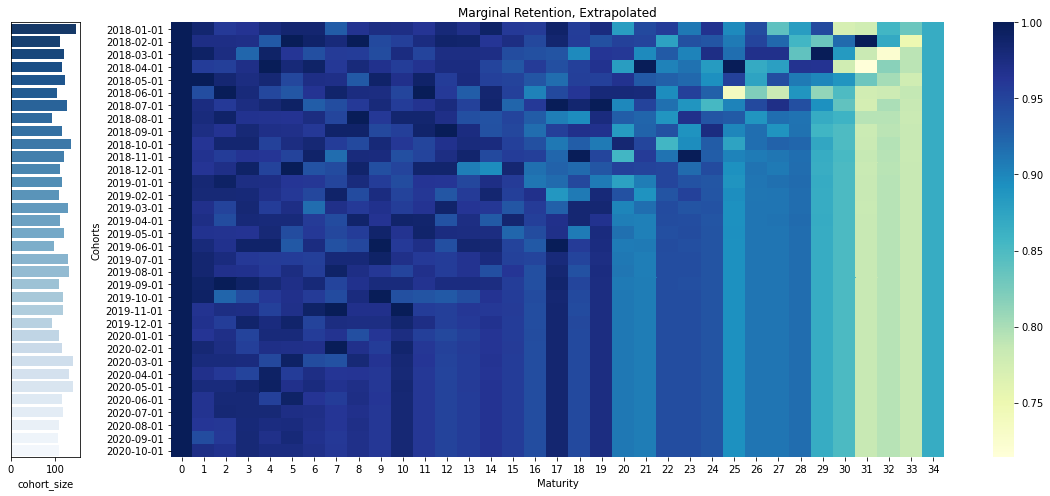

In [ ]:
plot_heatmap(cohorts, df_marginal_e, "Marginal Retention, Extrapolated", "Maturity", "Cohorts"
        , df_marginal_e.index.strftime('%Y-%m-%d')
        , if_annot = False)

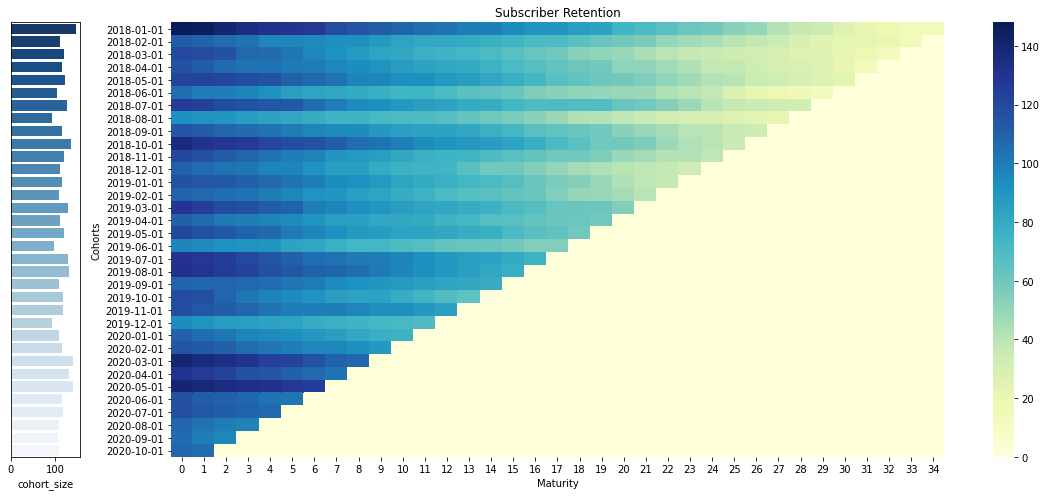

In [ ]:
plot_heatmap(cohorts, retention_sub, "Subscriber Retention", "Maturity", "Cohorts"
        , retention_sub.index.strftime('%Y-%m-%d')
        , if_annot = False)

In [ ]:
retention_matrix_e = retention_matrix.copy()
columns = retention_matrix_e.columns.values #assuming those are integers ????? - rethink
"""
Here we extrapolate Cohort Retention Matrix
We do this by i'th columns in marginal retention matrix by (i-1)th column in cohort retention matrix.
We only do it for 0 and NA values
"""
for column in columns[1:]:
  #row_indx = np.where(retention_matrix_e.loc[:, column].isna())[0] #OR 0??
  row_indx = np.where((retention_matrix_e.loc[:, column].isna()) | (retention_matrix_e.loc[:, column] == 0))[0] #OR 0??
  retention_matrix_e.iloc[row_indx, column] = retention_matrix_e.iloc[row_indx, column - 1] * df_marginal_e.iloc[row_indx, column]

retention_matrix_e

maturity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
subscription_bom,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.0,0.9865,0.945900,0.912200,0.891900,0.878400,0.864900,0.804100,0.777000,0.756800,0.736500,0.709500,0.695900,0.675700,0.668900,0.641900,0.614900,0.608100,0.581100,0.567600,0.500000,0.473000,0.452700,0.412200,0.398600,0.358100,0.337800,0.283800,0.250000,0.236500,0.182400,0.141900,0.121600,0.101400,0.087800
2018-02-01,1.0,0.9732,0.946400,0.919600,0.857100,0.857100,0.848200,0.830400,0.830400,0.785700,0.750000,0.732100,0.723200,0.714300,0.687500,0.669600,0.633900,0.625000,0.598200,0.562500,0.535700,0.508900,0.446400,0.419600,0.392900,0.357100,0.339300,0.312500,0.267900,0.223200,0.205400,0.205400,0.178600,0.133900,0.116047
2018-03-01,1.0,0.9917,0.966700,0.891700,0.883300,0.850000,0.800000,0.766700,0.733300,0.691700,0.675000,0.641700,0.625000,0.608300,0.591700,0.558300,0.525000,0.491700,0.441700,0.425000,0.408300,0.366700,0.341700,0.308300,0.300000,0.275000,0.266700,0.258300,0.216700,0.216700,0.191700,0.150000,0.108300,0.085738,0.074306
2018-04-01,1.0,0.9569,0.913800,0.887900,0.887900,0.870700,0.862100,0.827600,0.810300,0.784500,0.750000,0.724100,0.706900,0.689700,0.655200,0.612100,0.586200,0.551700,0.525900,0.508600,0.448300,0.448300,0.405200,0.370700,0.327600,0.327600,0.284500,0.250000,0.241400,0.232800,0.181000,0.129300,0.105549,0.083560,0.072418
2018-05-01,1.0,1.0000,0.983700,0.959300,0.943100,0.894300,0.869900,0.845500,0.788600,0.780500,0.756100,0.748000,0.715400,0.699200,0.666700,0.634100,0.593500,0.544700,0.520300,0.495900,0.479700,0.447200,0.414600,0.382100,0.341500,0.325200,0.284600,0.268300,0.243900,0.219500,0.195100,0.162381,0.130343,0.101378,0.087861
2018-06-01,1.0,0.9429,0.942900,0.923800,0.876200,0.819000,0.790500,0.781000,0.761900,0.742900,0.704800,0.704800,0.676200,0.628600,0.619000,0.590500,0.533300,0.504800,0.485700,0.476200,0.466700,0.457100,0.409500,0.390500,0.361900,0.266700,0.219000,0.171400,0.152400,0.123800,0.105283,0.081741,0.063792,0.050207,0.043512
2018-07-01,1.0,0.9764,0.937000,0.913400,0.897600,0.889800,0.826800,0.779500,0.748000,0.732300,0.700800,0.677200,0.661400,0.629900,0.622000,0.574800,0.551200,0.551200,0.543300,0.543300,0.488200,0.464600,0.425200,0.378000,0.322800,0.291300,0.275600,0.267700,0.252000,0.224850,0.188656,0.146082,0.116837,0.091775,0.079538
2018-08-01,1.0,0.9785,0.967700,0.935500,0.903200,0.871000,0.849500,0.806500,0.806500,0.774200,0.763400,0.752700,0.731200,0.688200,0.645200,0.612900,0.569900,0.516100,0.462400,0.451600,0.419400,0.387100,0.344100,0.333300,0.311800,0.290300,0.258100,0.236600,0.216028,0.187567,0.161205,0.128051,0.101712,0.079685,0.069060
2018-09-01,1.0,0.9739,0.939100,0.921700,0.895700,0.869600,0.834800,0.826100,0.817400,0.773900,0.739100,0.730400,0.730400,0.713000,0.669600,0.634800,0.582600,0.556500,0.539100,0.521700,0.460900,0.426100,0.400000,0.356500,0.347800,0.313000,0.287000,0.255497,0.233620,0.200369,0.170241,0.133075,0.105330,0.082718,0.071689


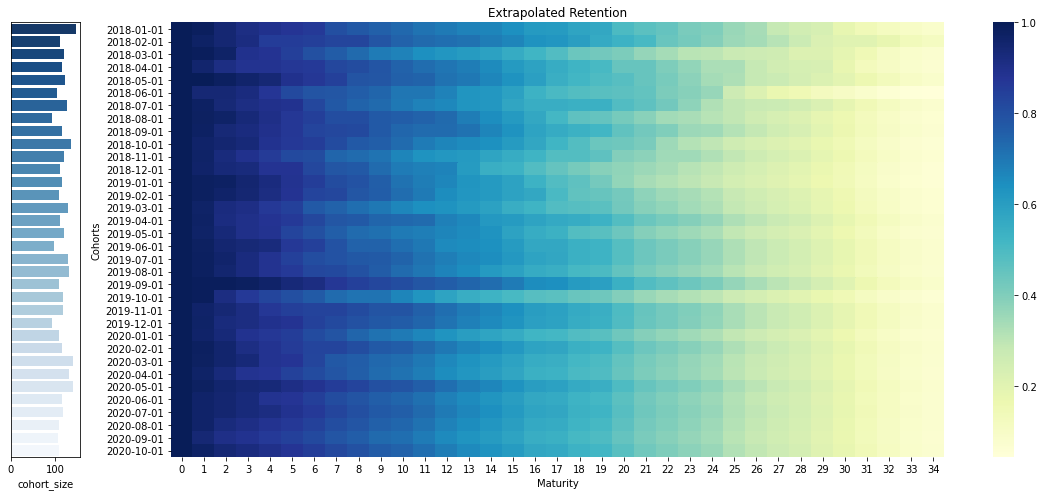

In [ ]:
plot_heatmap(cohorts, retention_matrix_e, "Extrapolated Retention", "Maturity", "Cohorts"
        , retention_sub.index.strftime('%Y-%m-%d')
        , if_annot = False)

# Lifetime

In [ ]:
lt_df = retention_matrix_e.sum(axis = 1).reset_index().rename(columns={0:'lifetime'})
value_df = random_df[['subscription_bom', 'value']].groupby('subscription_bom').mean().reset_index()

In [ ]:
ltv_df = lt_df.merge(value_df, how = 'left', left_on='subscription_bom', right_on = 'subscription_bom')
ltv_df = ltv_df.assign(ltv = ltv_df.lifetime * ltv_df.value)
ltv_df

,subscription_bom,lifetime,value,ltv
0,2018-01-01,19.655600,197.972973,3891.277568
1,2018-02-01,20.187247,205.357143,4145.595298
2,2018-03-01,17.726943,197.500000,3501.071308
3,2018-04-01,19.020327,209.482759,3984.430509
4,2018-05-01,19.522464,197.560976,3856.877044
5,2018-06-01,17.868535,199.047619,3556.689348
6,2018-07-01,18.769038,196.850394,3694.692469
7,2018-08-01,18.610208,210.752688,3922.151391
8,2018-09-01,19.113239,192.173913,3673.066003
9,2018-10-01,18.211302,186.764706,3401.228409


Text(0.5, 0, 'Cohort - Week of Acquisition')

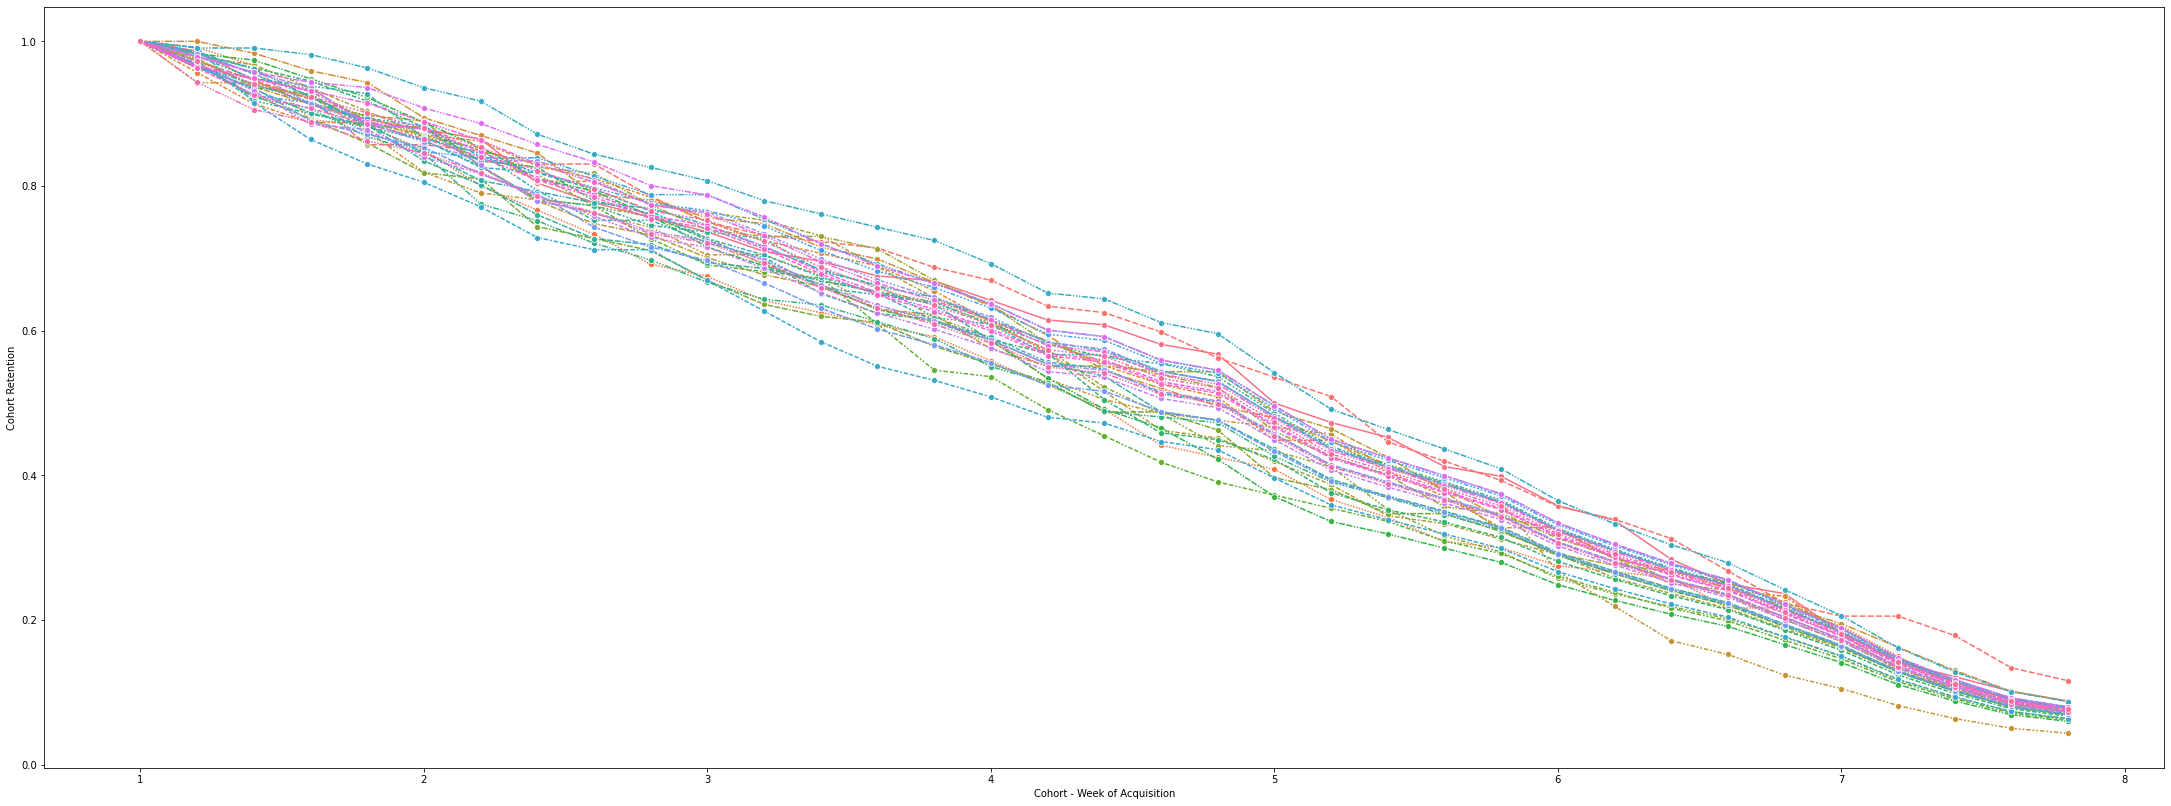

In [ ]:
plt.figure(figsize=(38,14))
ax = sns.lineplot(data = retention_matrix_e.transpose(), legend = False, marker="o")
ax.set_xticklabels(retention_matrix_e.transpose().index)
ax.set_ylabel("Cohort Retention")
ax.set_xlabel("Cohort - Week of Acquisition")

Text(0.5, 0, 'Cohort - Week of Acquisition')

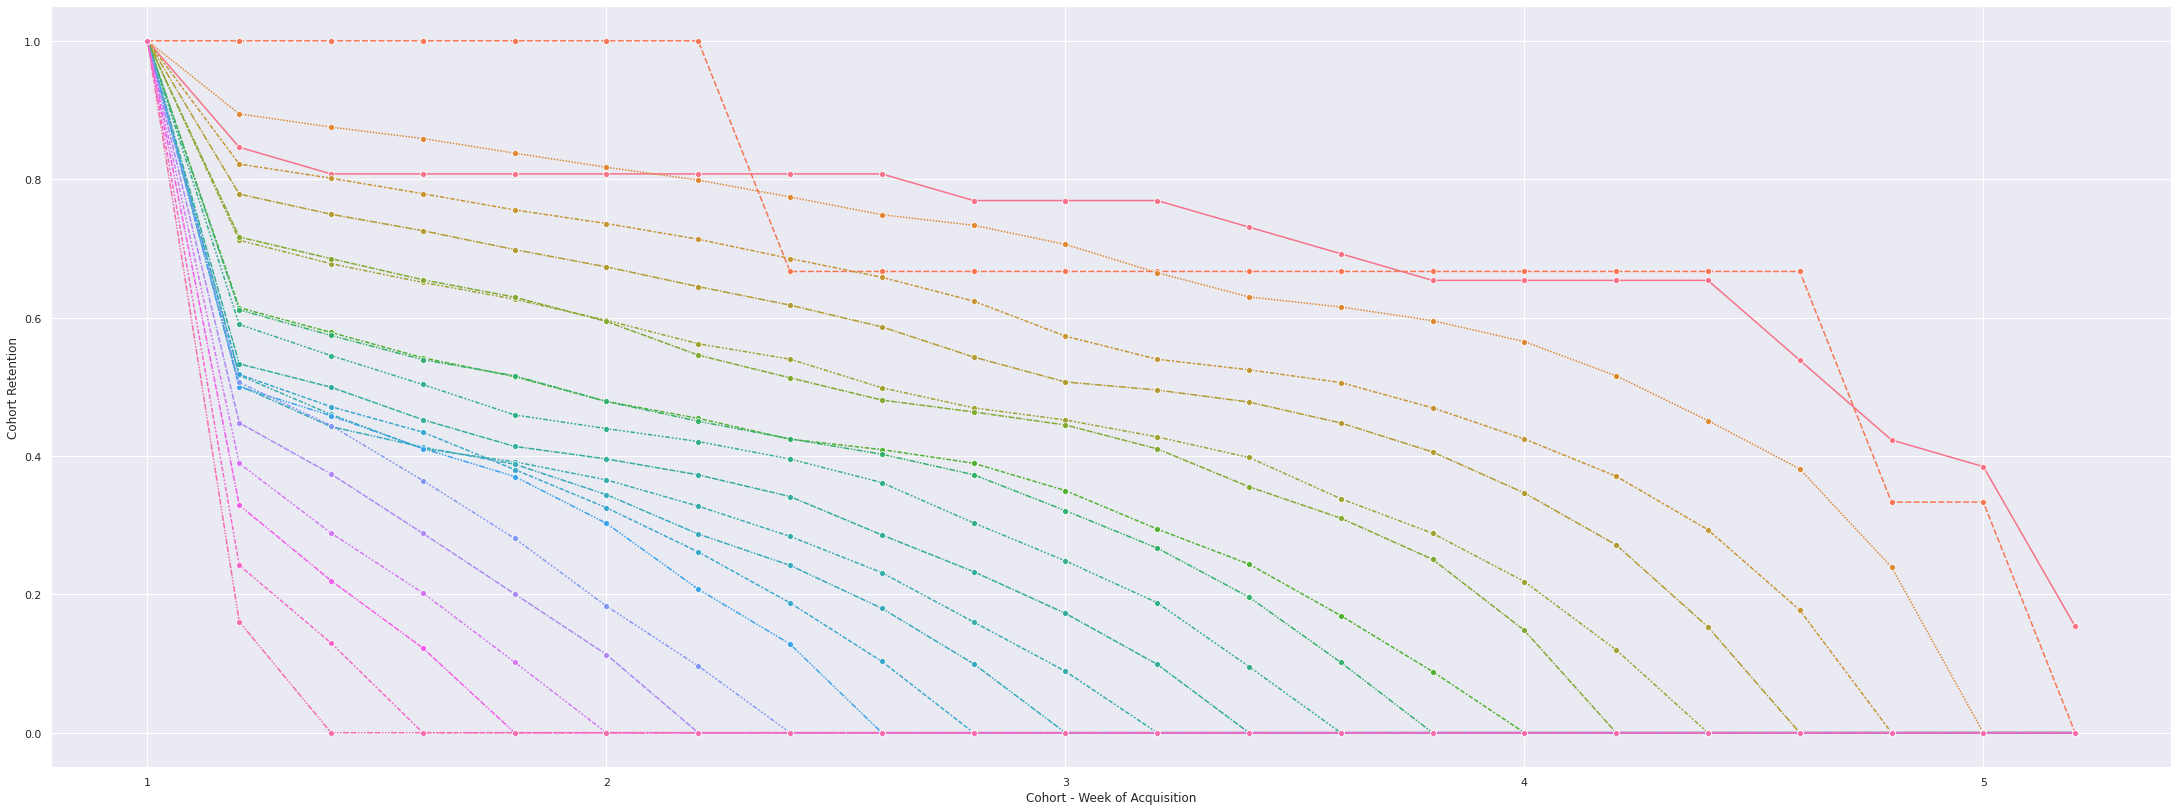

In [ ]:
plt.figure(figsize=(38,14))
ax = sns.lineplot(data = retention_matrix.transpose(), legend = False, marker="o")
ax.set_xticklabels(retention_matrix.transpose().index)
#ax.set(xticks = retention_matrix_e.transpose().columns.values.astype(dtype='datetime64[D]'))
ax.set_ylabel("Cohort Retention")
ax.set_xlabel("Cohort - Week of Acquisition")

# ax.set_yticklabels(retention_matrix_e.index.strftime('%Y-%m-%d'))
#ax.set_xticklabels(retention_matrix_e.columns.values)

Text(0.5, 0, 'Maturity - Weeks after Acquisition')

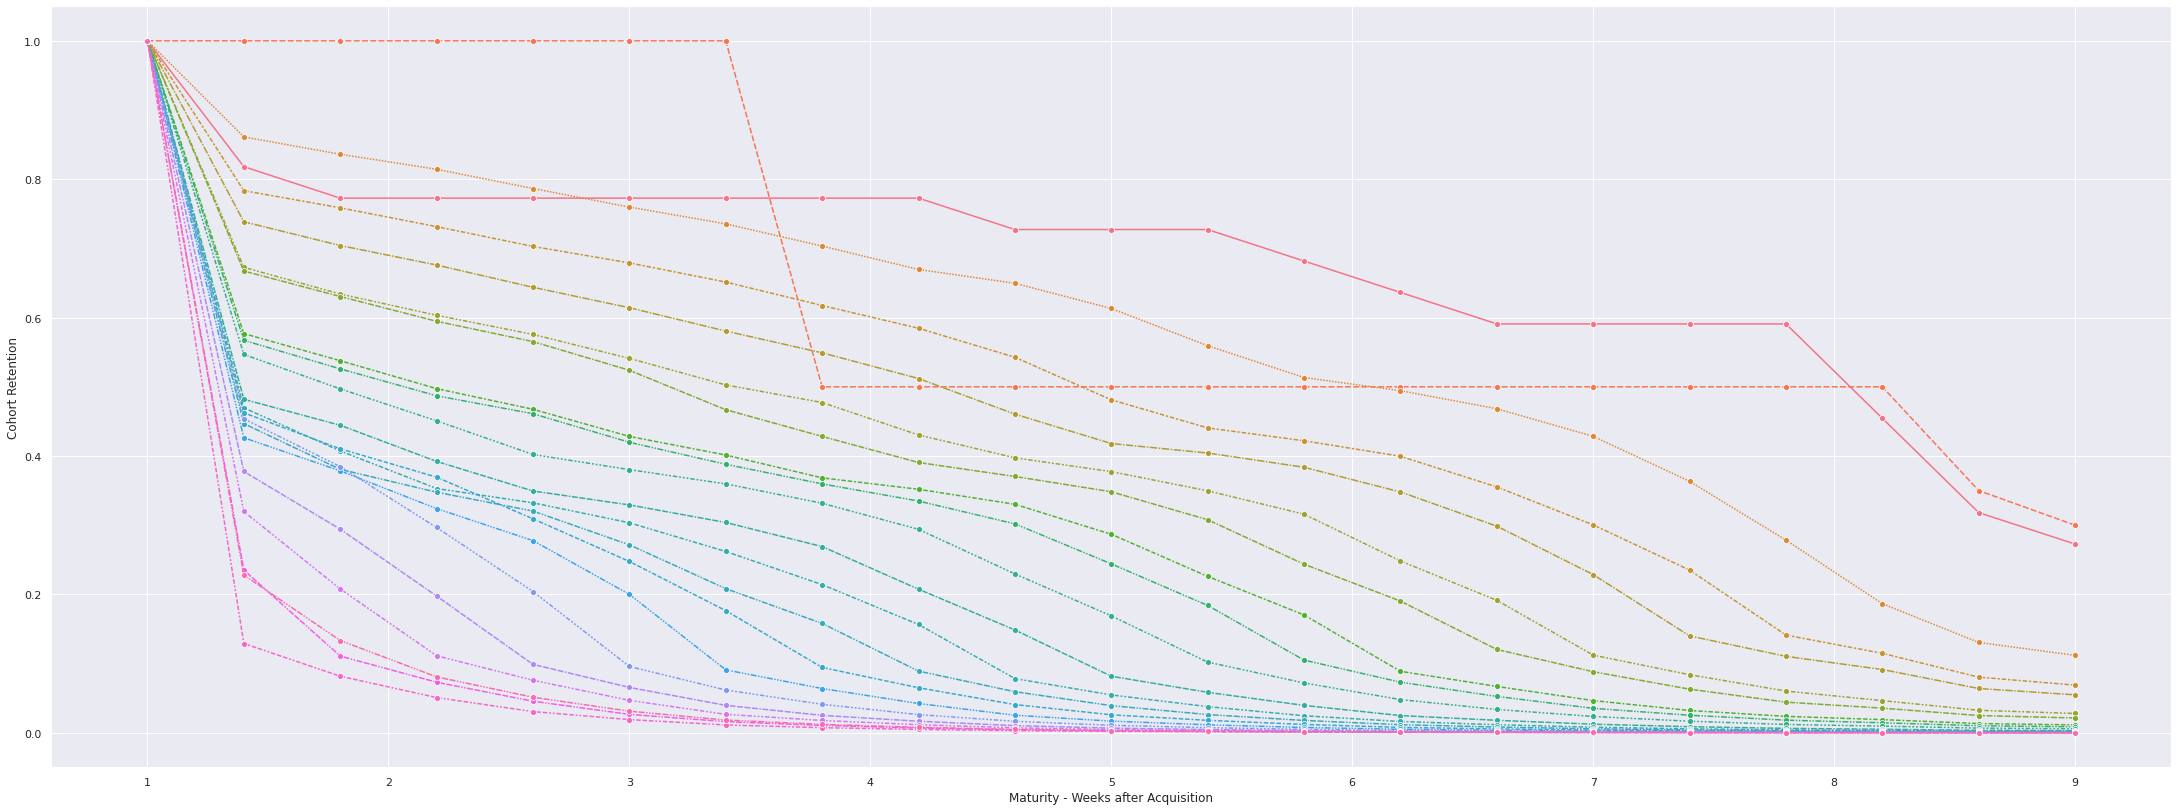

In [ ]:
plt.figure(figsize=(38,14))
ax = sns.lineplot(data = retention_matrix_e.transpose(), legend = False, marker="o")
ax.set_xticklabels(retention_matrix_e.transpose().index)
#ax.set(xticks = retention_matrix_e.transpose().columns.values.astype(dtype='datetime64[D]'))
ax.set_ylabel("Cohort Retention")
ax.set_xlabel("Maturity - Weeks after Acquisition")

# ax.set_yticklabels(retention_matrix_e.index.strftime('%Y-%m-%d'))
#ax.set_xticklabels(retention_matrix_e.columns.values)